In [1]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset, ConcatDataset
import torch.nn as nn
import torchvision
import torch
from torch import optim
import time
# resnet默认图片输入大小为224*224*3

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
data_root = './autodl-tmp/cifar-10'
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)
data_train = CIFAR10(data_root,
                   train=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(cifar10_mean, cifar10_std)]))
data_test = CIFAR10(data_root,
                  train=False,
                  transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(cifar10_mean, cifar10_std)]))

In [3]:
data_train_loader = DataLoader(data_train, batch_size=256, shuffle=True, num_workers=8)
data_test_loader = DataLoader(data_test, batch_size=256, num_workers=8)

In [4]:
net = torchvision.models.resnet18(pretrained=False)
# 修改模型
net.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1, bias=False)  # 首层改成3x3卷积核
net.maxpool = nn.MaxPool2d(1, 1, 0)  # 图像太小 本来就没什么特征 所以这里通过1x1的池化核让池化层失效
num_ftrs = net.fc.in_features  # 获取（fc）层的输入的特征数
net.fc = nn.Linear(num_ftrs, 10)
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=5e-4)

In [5]:
len(data_test)

10000

In [6]:
def train(epoch):
    
    global cur_batch_win
    net.train()
    loss_list, batch_list = [], []
    total_correct = 0
    for i, (images, labels) in enumerate(data_train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss_list.append(loss.detach().cpu().item())
        batch_list.append(i+1)
        pred = output.detach().max(1)[1]
        total_correct += pred.eq(labels.view_as(pred)).sum()
        # if i % 10 == 0:
            # print('Train - Epoch %d, Batch: %d, Loss: %f' % (epoch, i, loss.detach().cpu().item()))
        loss.backward()
        optimizer.step()
    
    # 每一轮结束输出一下当前的学习率 lr
    lr_1 = optimizer.param_groups[0]['lr']
    print("learn_rate:%.15f" % lr_1)
    
    avg_loss = sum(loss_list) / len(loss_list)
    acc = float(total_correct) / len(data_train)
    print('Train Avg. Loss: %f, Accuracy: %f' % (avg_loss, acc))
    return acc, avg_loss

In [7]:
def test():
    net.eval()
    batch_list = []
    with torch.no_grad():
        total_correct = 0
        avg_loss = 0.0
        for i, (images, labels) in enumerate(data_test_loader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)
            avg_loss += criterion(output, labels).sum()
            pred = output.detach().max(1)[1]
            total_correct += pred.eq(labels.view_as(pred)).sum()
            batch_list.append(i+1)

    avg_loss /= batch_list[-1]
    avg_loss = avg_loss.detach().cpu().item()
    acc = float(total_correct) / len(data_test)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss, acc))
    return acc, avg_loss

In [8]:
def train_and_test(epoch):
    print('training...')
    acc, loss = train(epoch)
    val_acc, val_loss = test()
    return acc, loss, val_acc, val_loss

In [9]:
epoch = 100
acc, loss, val_acc, val_loss = [], [], [], []

start = time.time()
for e in range(epoch):
    if e>=20 and e<50:
        optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=5e-5)
    elif e>=50:
        optimizer = optim.Adam(net.parameters(), lr=1e-5, weight_decay=5e-6)
    a, b, c, d = train_and_test(e)
    acc.append(a)
    loss.append(b)
    val_acc.append(c)
    val_loss.append(d)
    print(f'lenet_epoch={e} test_acc={c:0.3f}')
    if e % 10 == 0:
        torch.save(net.state_dict(), f'autodl-tmp/save_model/cifar/res18/epoch={e}_test_acc={c:0.3f}.pth')
end = time.time()
# 计算并打印输出你的训练时间
print("total time:{}".format(end - start))

training...
learn_rate:0.001000000000000
Train Avg. Loss: 1.266019, Accuracy: 0.538420
Test Avg. Loss: 1.439146, Accuracy: 0.550800
lenet_epoch=0 test_acc=0.551
training...
learn_rate:0.001000000000000
Train Avg. Loss: 0.798821, Accuracy: 0.718480
Test Avg. Loss: 0.851540, Accuracy: 0.696000
lenet_epoch=1 test_acc=0.696
training...
learn_rate:0.001000000000000
Train Avg. Loss: 0.616340, Accuracy: 0.782440
Test Avg. Loss: 0.770343, Accuracy: 0.738700
lenet_epoch=2 test_acc=0.739
training...
learn_rate:0.001000000000000
Train Avg. Loss: 0.520733, Accuracy: 0.820440
Test Avg. Loss: 0.967694, Accuracy: 0.691900
lenet_epoch=3 test_acc=0.692
training...
learn_rate:0.001000000000000
Train Avg. Loss: 0.453749, Accuracy: 0.843120
Test Avg. Loss: 0.730910, Accuracy: 0.758400
lenet_epoch=4 test_acc=0.758
training...
learn_rate:0.001000000000000
Train Avg. Loss: 0.397151, Accuracy: 0.862800
Test Avg. Loss: 0.678975, Accuracy: 0.774200
lenet_epoch=5 test_acc=0.774
training...
learn_rate:0.001000000

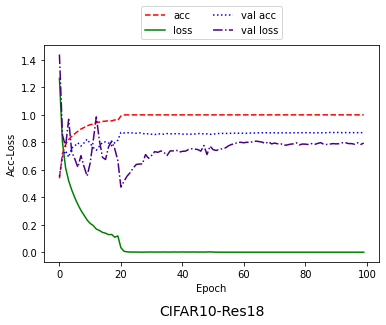

In [10]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(epoch)
plt.plot(x, acc, color='red', linestyle='--', label="acc")
plt.plot(x, loss, color='green', label="loss")
plt.plot(x, val_acc, color='blue', linestyle='dotted', label="val acc")
plt.plot(x, val_loss, color='indigo', linestyle='dashdot', label="val loss")
plt.title('CIFAR10-Res18', fontsize=14, y=-0.27)
plt.xlabel('Epoch')
plt.ylabel('Acc-Loss')
plt.xticks(ticks=[0,20,40,60,80,100])
# 添加图例
plt.legend(loc='center',bbox_to_anchor=(0.5, 1.1),ncol=2)
plt.show()

In [15]:
val_loss

[1.4391462802886963,
 0.8515400886535645,
 0.7703432440757751,
 0.9676942825317383,
 0.7309103012084961,
 0.6789747476577759,
 0.618171215057373,
 0.7035374045372009,
 0.6239367723464966,
 0.5547986626625061,
 0.6481101512908936,
 0.8132286071777344,
 0.9851436614990234,
 0.815220832824707,
 0.6912220120429993,
 0.67476487159729,
 0.7681045532226562,
 0.808871865272522,
 0.7524017095565796,
 0.6677535176277161,
 0.47411856055259705,
 0.515946090221405,
 0.5536640286445618,
 0.5789768099784851,
 0.6128631234169006,
 0.6390239596366882,
 0.6419541239738464,
 0.6425384879112244,
 0.7110073566436768,
 0.6841235756874084,
 0.7048077583312988,
 0.7322810292243958,
 0.7269726395606995,
 0.7373123168945312,
 0.7269840240478516,
 0.7036914229393005,
 0.7372052669525146,
 0.7380790114402771,
 0.7425115704536438,
 0.728717029094696,
 0.7343616485595703,
 0.7359535098075867,
 0.7474923729896545,
 0.753048837184906,
 0.7507722973823547,
 0.7474239468574524,
 0.7359098792076111,
 0.7766382694244385,

In [16]:
val_acc

[0.5508,
 0.696,
 0.7387,
 0.6919,
 0.7584,
 0.7742,
 0.7961,
 0.7728,
 0.7954,
 0.8228,
 0.7923,
 0.7628,
 0.7425,
 0.7709,
 0.7991,
 0.803,
 0.7953,
 0.7753,
 0.7975,
 0.8153,
 0.8717,
 0.8681,
 0.8693,
 0.8704,
 0.8677,
 0.8661,
 0.8691,
 0.8664,
 0.8581,
 0.8638,
 0.859,
 0.8562,
 0.8623,
 0.8601,
 0.8595,
 0.8636,
 0.8625,
 0.8602,
 0.864,
 0.8629,
 0.8596,
 0.8592,
 0.8605,
 0.8592,
 0.8605,
 0.8633,
 0.8643,
 0.8607,
 0.8618,
 0.8585,
 0.8602,
 0.8622,
 0.865,
 0.8652,
 0.8648,
 0.8648,
 0.8664,
 0.8665,
 0.8661,
 0.8673,
 0.8651,
 0.8658,
 0.8673,
 0.8679,
 0.868,
 0.8694,
 0.8696,
 0.8698,
 0.8697,
 0.8684,
 0.8699,
 0.8687,
 0.8683,
 0.87,
 0.8685,
 0.8689,
 0.8694,
 0.8695,
 0.8695,
 0.8699,
 0.8702,
 0.8706,
 0.8692,
 0.8687,
 0.8697,
 0.8693,
 0.8693,
 0.8701,
 0.8716,
 0.871,
 0.8715,
 0.872,
 0.8698,
 0.871,
 0.8702,
 0.8714,
 0.8701,
 0.8704,
 0.8706,
 0.8705]

In [17]:
acc

[0.53842,
 0.71848,
 0.78244,
 0.82044,
 0.84312,
 0.8628,
 0.88034,
 0.8966,
 0.9078,
 0.9199,
 0.92794,
 0.9329,
 0.94356,
 0.94706,
 0.95198,
 0.95412,
 0.9571,
 0.956,
 0.96318,
 0.96046,
 0.99146,
 0.99926,
 0.9999,
 0.99996,
 0.99986,
 0.9998,
 0.99998,
 0.99998,
 0.99982,
 0.99984,
 0.99976,
 0.9999,
 0.9998,
 0.99978,
 0.99968,
 0.99984,
 0.99982,
 0.9997,
 0.99978,
 0.99972,
 0.99964,
 0.99972,
 0.9997,
 0.99976,
 0.99966,
 0.99988,
 0.9997,
 0.99978,
 0.99968,
 0.99944,
 0.9998,
 0.99994,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [18]:
loss

[1.266019090401883,
 0.7988207787275314,
 0.6163400151595777,
 0.5207334025477877,
 0.45374926362110646,
 0.39715149398056826,
 0.34741515042830484,
 0.3047916265774746,
 0.26980828440615107,
 0.2344809860295179,
 0.20985929975856324,
 0.1939971369824239,
 0.1682604527367013,
 0.15834180505148002,
 0.14441913031801887,
 0.13857273829682748,
 0.12798933798865397,
 0.12901694251566517,
 0.10906034164434793,
 0.11894982087672973,
 0.03252101184001991,
 0.007007153920962342,
 0.0026868752421269535,
 0.0013050917693121567,
 0.0011420901771219047,
 0.0011650772382325863,
 0.0005715234692615923,
 0.00045678044402940976,
 0.0009008793395525795,
 0.0011732558374131592,
 0.00125472216202571,
 0.0010001754389846536,
 0.000984990944725352,
 0.0010761986273532134,
 0.0015302381390790046,
 0.0009274556663030478,
 0.0009422078543807124,
 0.0016003981982252373,
 0.0013596590201350224,
 0.0013098693739730337,
 0.001770234570581031,
 0.0013563011530745175,
 0.0012257706914949398,
 0.0012342492044233357,